In [1]:
# pip install xgboost

In [2]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preprocessing
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metric
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, make_scorer, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from scipy.stats import kruskal, mannwhitneyu

from sklearn.ensemble import StackingClassifier, VotingClassifier,BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

Hotel Booking Demand
Context
This data set contains booking information for a hotel located in Portugal, and includes information regarding room reservation for respective customers.
All personally identifying information has been removed from the data.

| Column Name | Description |
|-------------|-------------|
| country | Country of origin |
| market_segment | Market segment designation |
| previous_cancellations | Number of previous bookings cancelled by customer |
| booking_changes | Number of changes made to booking |
| deposit_type | Indication of deposit made to guarantee booking |
| days_in_waiting_list | Number of days booking was in waiting list |
| customer_type | Type of booking |
| reserved_room_type | Code of room type reserved |
| required_car_parking_space | Number of required car parking spaces |
| total_of_special_request | Number of special requests made by customer |
| is_canceled | Indicates if booking was canceled (1) or not (0) |


Identifying Business Problem

- False Negative: The prediction was that the customer would not cancel, but they did cancel.
- False Positive: The prediction was that the customer would cancel, but they did not cancel.
- True Negative: The prediction was that the customer would not cancel, and they did not cancel.
- True Positive: The prediction was that the customer would cancel, and they actually did cancel.

    - False Negative cost: $140
    - False Positive cost: 0

A false negative could result in a loss of revenue if the room is not resold or relisted in time On the other hand, a false positive may result in inconvenience or frustration for the customer, but it is unlikely to have a significant impact on the overall business.

Code below is for data load, we're using csv file of data_hotel_booking_demand

In [3]:
df = pd.read_csv('data_hotel_booking_demand.csv')

Code below is for checking the missing data in country columns

In [4]:
kolom_country_kosong = df[df['country'].isna()].index

In [5]:
df.loc[kolom_country_kosong]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
814,NaN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1166,NaN,Direct,2,0,No Deposit,0,Transient,E,0,3,1
1304,NaN,Direct,0,1,No Deposit,0,Transient,D,0,1,0
1661,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
2182,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
82466,NaN,Offline TA/TO,0,0,No Deposit,0,Transient,A,0,0,0
83084,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
83106,NaN,Direct,0,0,No Deposit,0,Transient,A,0,2,0
83353,NaN,Direct,0,0,No Deposit,0,Transient,A,0,0,0


Code below is for checking the number of unique country

In [6]:
df['country'].nunique()

162

Code Below is for checking whether the target is imbalance or not

In [7]:
df['is_canceled'].value_counts()

0    52795
1    30778
Name: is_canceled, dtype: int64

# EDA

Code Below is for getting the columns that are categorical

In [8]:
category_columns = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
category_columns

['country',
 'market_segment',
 'deposit_type',
 'customer_type',
 'reserved_room_type']

this code below is for getting the unique values of the categorical column, which we loop to get all the columns unique values at once

In [9]:
for i in category_columns:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in country:  162
Unique values:  ['IRL' 'FRA' 'PRT' 'NLD' 'ESP' 'UMI' 'CN' 'LUX' 'BRA' 'BEL' 'JPN' 'DEU'
 'ITA' 'CHE' 'GBR' 'AGO' 'SRB' 'COL' 'CHN' 'SWE' 'AUT' 'CIV' 'CZE' 'POL'
 'USA' 'SGP' 'RUS' 'ROU' 'DNK' 'IND' 'MAR' 'PHL' 'ARG' 'ISL' 'ZAF' 'LBN'
 'MOZ' 'TUR' 'BGD' 'MEX' 'CAF' 'NOR' 'FIN' 'UKR' 'EGY' 'ISR' nan 'KOR'
 'AZE' 'HUN' 'AUS' 'EST' 'CHL' 'SVN' 'PRY' 'ABW' 'ALB' 'LTU' 'ARE' 'HRV'
 'SAU' 'NZL' 'LVA' 'ATA' 'KAZ' 'DZA' 'TWN' 'CRI' 'BIH' 'BGR' 'IRQ' 'OMN'
 'VEN' 'IDN' 'GEO' 'MLT' 'IRN' 'BLR' 'URY' 'LBY' 'TUN' 'BEN' 'MYS' 'MWI'
 'GRC' 'CYP' 'CPV' 'HKG' 'PRI' 'MKD' 'MUS' 'IMN' 'PAN' 'NGA' 'GLP' 'KHM'
 'PER' 'QAT' 'SEN' 'MAC' 'SVK' 'BHR' 'ECU' 'SYC' 'BOL' 'TJK' 'LCA' 'MDV'
 'SYR' 'ZMB' 'LIE' 'THA' 'MNE' 'BRB' 'CMR' 'JEY' 'GTM' 'LKA' 'JOR' 'TZA'
 'AND' 'ARM' 'GIB' 'VNM' 'PAK' 'JAM' 'DOM' 'KWT' 'LAO' 'RWA' 'FRO' 'GAB'
 'ETH' 'CUB' 'COM' 'GNB' 'GGY' 'NIC' 'TGO' 'TMP' 'CYM' 'GHA' 'SLE' 'BWA'
 'NCL' 'UZB' 'SUR' 'SDN' 'PLW' 'MLI' 'MMR' 'BFA' 'SLV' 'BDI' 'ZWE' 'UGA'
 

Country : will use Binary Encoder because there's so many unique values

Market_segment : OneHot Encoder, Because there is no level of importance between each unique values, and because its just 8 unique values so we use Onehot

Deposit Type : OneHot Encoder, Because there is no levels and just a few unique values

Customer_type : OneHot Encoder, Because there is no levels and just a few unique values

Reserved_room_type : Ordinal Encoder, we will use ordinal because there is levels between unique values

Code Below Drop the Undefined because its just 1 and because it will not be in test set, resultin in an error in the cross validation

In [10]:
df = df[~(df['market_segment'] == 'Undefined')]

Code below is for checking the outliers of numerical columns with barplot, and im using looping to show it all at once

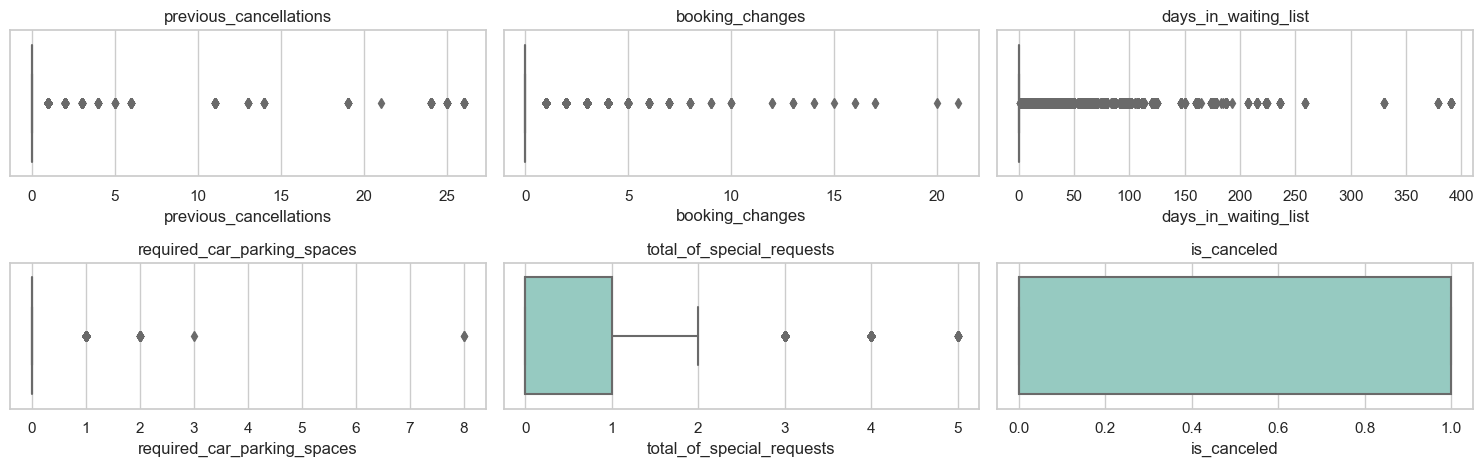

In [11]:
# Numerical Features
num_feature = [fea for fea in df.describe().columns]
num_feature

plt.figure(figsize=(15, 9), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(4,3, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=12)
    plt.tight_layout()
    plotnumber += 1

Days In Waiting List : drop outliers that the values is more than 130 because its too far

I dont drop outliers from another columns because tha values directly correlate with the machine learning target

In [12]:
len(df)

83572

Dropping the waiting list outliers that are above 130 days waiting list

In [13]:

df = df[~(df['days_in_waiting_list'] > 130)]

so after i dropped the outlier from the waiting list column, the data is cutdown from 83573 to 83233

In [14]:
len(df)

83232

# Define X and y

In [15]:
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [16]:
X = df.drop(columns='is_canceled')

y = df['is_canceled']

# Data Splitting

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=21,stratify=y)

# Pre-processing

Checking if there is any NaN value in the data, so we can preprocess it

In [18]:
X.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
dtype: int64

Checking if there is any duplicated data that we need to drop

In [19]:
X.duplicated().sum()

74456

After conducting a thorough review, it has been determined that the duplicated data is not the result of formatting or data errors. Additionally, it has been confirmed that the cross-validation results are stable, indicating that the presence of duplicated data does not contribute to overfitting. As a result, there is no need to remove the duplicated data.

## Creating Pipeline and Column Transformer for pre-processing 

Country : will use Binary Encoder because there's so many unique values

Market_segment : OneHot Encoder, Because there is no level of importance between each unique values, and because its just 8 unique values so we use Onehot

Deposit Type : OneHot Encoder, Because there is no levels and just a few unique values

Customer_type : OneHot Encoder, Because there is no levels and just a few unique values

Reserved_room_type : Onehot Encoder, Because there is no levels and just a few unique values

In [20]:
X.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,83232.000000,83232.000000,83232.000000,83232.000000,83232.000000
mean,0.087154,0.221237,1.442991,0.063257,0.575235
std,0.842713,0.649492,9.912189,0.247392,0.795958
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,26.000000,21.000000,125.000000,8.000000,5.000000


Scaling: ['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']

In [21]:
#Creating pipeline for country that we will fill the missing values with others using simpleimputer constant 
# binaryencoder because there's so many unqiue values

pipe_const_binary = Pipeline([
    ('const',SimpleImputer(strategy='constant',fill_value='Others')),
    ('binary', BinaryEncoder())
])

#Creating pipeline for 'market_Segment','deposit_type','customer_type','reserved_room_type' column 
# that we will encode using onehot encoder

pipe_onehot = Pipeline([
    ('onehot',OneHotEncoder(drop='first'))
])

pipe_poly_scaling = Pipeline([
    ('poly',PolynomialFeatures(degree=1)),
    ('scaling',RobustScaler())
])

#Creating columnstransformer for the pipeline

transformer = ColumnTransformer([
    ('pipe_const_binary_scale',pipe_const_binary,['country']),
    ('pipe_onehot',pipe_onehot,['market_segment','deposit_type','customer_type','reserved_room_type']),
    ('pipe_poly_scaling',pipe_poly_scaling,['previous_cancellations','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests'])
],remainder='passthrough')



# Cross Validation

This steps is to find the best benchmark algorithm

In [22]:
# 3 Base Learner (Basic ML algorithm)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, max_depth=5)


# 4 ensemble model
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost  = XGBClassifier()

This code below is to see the best algorithm for our case, and to check that i will create a loop checking each and everyone of the algorithm

In [23]:
list_model = [logreg,knn,tree,rf,adaboost,gboost,xgboost]           #containing all the algorithm to use in the looping
list_all = []
list_mean = []
list_std = []

#Create a loop to check each algorithm in list_model to find the mean and std so we can choose the best algorithm to use
for model in list_model:

    pipe_model = Pipeline([
        ('transformer',transformer),
        ('sampling',RandomOverSampler(random_state=0)),
        ('model', model)
    ])

    model_cv = cross_val_score(
        estimator=pipe_model,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring='recall',
        error_score='raise'

    )

    list_all.append(model_cv.round(4))
    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())

Code Below is for creating the dataframe of the cross validaiton result so we can see it more clearly and better

In [24]:
df_score = pd.DataFrame({
    'algo':list_model,
    'mean' : list_mean,
    'std' : list_std,
    'all' : list_all
})

In [25]:
df_score

,algo,mean,std,all
0,LogisticRegression(random_state=0),0.723653,0.014875,"[0.6989, 0.736, 0.714, 0.7348, 0.7346]"
1,KNeighborsClassifier(),0.647994,0.036669,"[0.7203, 0.6311, 0.6399, 0.6207, 0.6281]"
2,"DecisionTreeClassifier(max_depth=5, random_sta...",0.619493,0.005201,"[0.6235, 0.6121, 0.6268, 0.6188, 0.6162]"
3,RandomForestClassifier(random_state=0),0.802254,0.007408,"[0.8016, 0.8032, 0.8154, 0.7934, 0.7977]"
4,AdaBoostClassifier(random_state=0),0.693071,0.005702,"[0.6909, 0.6893, 0.7044, 0.6913, 0.6895]"
5,GradientBoostingClassifier(random_state=0),0.765710,0.006958,"[0.7638, 0.7642, 0.7793, 0.7605, 0.7608]"
6,"XGBClassifier(base_score=None, booster=None, c...",0.787106,0.008320,"[0.785, 0.7826, 0.8036, 0.7828, 0.7816]"


Out of all algorithm above Random Forest algorithm have the best mean, and one of the lowest standard deviation, in this case i will use Random Forest algorithm and XGBoost because it is the 2nd best so we can have like second opinion

# Hyperparameter Tuning

## Random Forest Tuning

In [26]:
#this is the pipeline we use
pipe_model = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler()),
    ('model', rf)
])

#this is for the param distribution, containing the parameter that we wants to tune to find the best one

hyperparam_space = {
    'model__n_estimators': range(50, 501, 50),
    'model__max_features': range(1, len(X.columns), 1),
    'model__max_depth': range(3,50,1),
    'model__min_samples_split': range(2,100,2),
    'model__min_samples_leaf': range(2,100,2),
    'transformer__pipe_poly_scaling__poly__degree':[1,2,3],
    'transformer__pipe_poly_scaling__scaling': [RobustScaler(),MinMaxScaler(),StandardScaler()],
    'sampling':[RandomUnderSampler(random_state=0),RandomOverSampler(random_state=0),SMOTE(),NearMiss()]
}

#using random search to see the best parameter
randomsearch_rf = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions= hyperparam_space,
    cv=5,
    scoring = 'recall',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

this code below is for fitting the Random Search for Random Forest best params to X_train and y_train

In [27]:
randomsearch_rf.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_const_binary_scale',
                                                                               Pipeline(steps=[('const',
                                                                                                SimpleImputer(fill_value='Others',
                                                                                                              strategy='constant')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['country']),
                                                                              ('pipe_onehot',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['marke...
                                        'model__min_samples_split': range(2, 100, 2),
                                        'model__n_estimators': range(50, 501, 50),
                                        'sampling': [RandomUnderSampler(random_state=0),
                                                     RandomOverSampler(random_state=0),
                                                     SMOTE(), NearMiss()],
                                        'transformer__pipe_poly_scaling__poly__degree': [1,
                                                                                         2,
                                                                                         3],
                                        'transformer__pipe_poly_scaling__scaling': [RobustScaler(),
                                                                                    MinMaxScaler(),
                                                                                    StandardScaler()]},
                   random_state=0, scoring='recall')

In [28]:
randomsearch_rf.best_params_

{'transformer__pipe_poly_scaling__scaling': RobustScaler(),
 'transformer__pipe_poly_scaling__poly__degree': 1,
 'sampling': RandomOverSampler(random_state=0),
 'model__n_estimators': 250,
 'model__min_samples_split': 16,
 'model__min_samples_leaf': 2,
 'model__max_features': 1,
 'model__max_depth': 33}

## XGBoost Tuning

In [31]:
#this is the pipeline we use
pipe_model = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler(random_state=0)),
    ('model', xgboost)
])


#this is for the param distribution, containing the parameter that we wants to tune to find the best one
hyperparam_space = {
    'model__max_depth': range(3,50,1),
    'model__min_child_weight': range(1,6,2),
    'model__gamma': [i/10.0 for i in range(0,5)],
    'model__subsample': [i/10.0 for i in range(6,10)],
    'model__colsample_bytree': [i/10.0 for i in range(6,10)],
    'transformer__pipe_poly_scaling__poly__degree':[1,2,3],
    'transformer__pipe_poly_scaling__scaling': [RobustScaler(),MinMaxScaler(),StandardScaler()],
    'sampling':[RandomUnderSampler(random_state=0),RandomOverSampler(random_state=0), SMOTE(), NearMiss()]
}

#using randomized search to find the best parameter to produce the best score 
randomsearch_xg = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions= hyperparam_space,
    cv=5,                           
    scoring = 'recall',                                 #Using The recall score because the false negative is more dangerous
    n_jobs=-1,                                          #To use all the processor in our laptop/PC 
    n_iter=200,                                         #Number of randomized search
    random_state=0
)

this is to fit the XGBoost randomized search to the train set

In [32]:
randomsearch_xg.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_const_binary_scale',
                                                                               Pipeline(steps=[('const',
                                                                                                SimpleImputer(fill_value='Others',
                                                                                                              strategy='constant')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['country']),
                                                                              ('pipe_onehot',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['marke...
                                        'model__min_child_weight': range(1, 6, 2),
                                        'model__subsample': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'sampling': [RandomUnderSampler(random_state=0),
                                                     RandomOverSampler(random_state=0),
                                                     SMOTE(), NearMiss()],
                                        'transformer__pipe_poly_scaling__poly__degree': [1,
                                                                                         2,
                                                                                         3],
                                        'transformer__pipe_poly_scaling__scaling': [RobustScaler(),
                                                                                    MinMaxScaler(),
                                                                                    StandardScaler()]},
                   random_state=0, scoring='recall')

To Check the best parameters for XGBoost

In [33]:
randomsearch_xg.best_params_

{'transformer__pipe_poly_scaling__scaling': StandardScaler(),
 'transformer__pipe_poly_scaling__poly__degree': 3,
 'sampling': RandomUnderSampler(random_state=0),
 'model__subsample': 0.6,
 'model__min_child_weight': 1,
 'model__max_depth': 44,
 'model__gamma': 0.0,
 'model__colsample_bytree': 0.8}

## 2nd Random Forest Tuning 

we will narrow the range for the 2nd tuning of random forest within the best params range of our first tuning  

In [37]:
# this is the best params of the 1st random forest tuning
randomsearch_rf.best_params_

{'transformer__pipe_poly_scaling__scaling': RobustScaler(),
 'transformer__pipe_poly_scaling__poly__degree': 1,
 'sampling': RandomOverSampler(random_state=0),
 'model__n_estimators': 250,
 'model__min_samples_split': 16,
 'model__min_samples_leaf': 2,
 'model__max_features': 1,
 'model__max_depth': 33}

In [39]:
#this is the pipeline we use
pipe_model = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler(random_state=0)),
    ('model', rf)
])

#this is for the param distribution, containing the parameter that we wants to tune to find the best one

hyperparam_space = {
    'model__n_estimators': range(200, 401, 20),
    'model__max_features': range(1, len(X.columns), 1),
    'model__max_depth': range(25,41,1),
    'model__min_samples_split': range(10,30,1),
    'model__min_samples_leaf': range(2,21,2),
    'transformer__pipe_poly_scaling__poly__degree':[1],
    'transformer__pipe_poly_scaling__scaling': [MinMaxScaler()],
}

#using random search to see the best parameter
randomsearch_rf_2nd = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions= hyperparam_space,
    cv=5,
    scoring = 'recall',
    n_jobs=-1,
    n_iter=500,
    random_state=0
)

In [40]:
# fitting the 2nd random forest random search
randomsearch_rf_2nd.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_const_binary_scale',
                                                                               Pipeline(steps=[('const',
                                                                                                SimpleImputer(fill_value='Others',
                                                                                                              strategy='constant')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['country']),
                                                                              ('pipe_onehot',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['marke...
                   param_distributions={'model__max_depth': range(25, 41),
                                        'model__max_features': range(1, 10),
                                        'model__min_samples_leaf': range(2, 21, 2),
                                        'model__min_samples_split': range(10, 30),
                                        'model__n_estimators': range(200, 401, 20),
                                        'transformer__pipe_poly_scaling__poly__degree': [1],
                                        'transformer__pipe_poly_scaling__scaling': [MinMaxScaler()]},
                   random_state=0, scoring='recall')

# Predict To Test Set

This code Below is for to see the Recall score of random forest before tuning

In [160]:
pipe_model_rf = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler(random_state=0)),
    ('model', rf)
])

pipe_model_rf.fit(X_train,y_train)

y_pred_before_rf = pipe_model.predict(X_test)
recall_score(y_test,y_pred_before_rf)

0.8030377266046056

This code Below is for to see the Recall score of random forest after tuning

In [159]:
best_model_rf = randomsearch_rf.best_estimator_


best_model_rf.fit(X_train,y_train)

y_pred_after_rf = best_model_rf.predict(X_test)
recall_score(y_test,y_pred_after_rf)

0.7855626326963907

This code below is the random forest 2nd tuning Recall Score

In [161]:
best_model_rf_2nd = randomsearch_rf_2nd.best_estimator_


best_model_rf_2nd.fit(X_train,y_train)

y_pred_after_rf_2nd = best_model_rf_2nd.predict(X_test)
recall_score(y_test,y_pred_after_rf_2nd)

0.7984648048342315

This code Below is for to see the Recall score of XGboost before tuning

In [165]:
pipe_model_xg = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomOverSampler(random_state=0)),
    ('model', xgboost)
])

pipe_model_xg.fit(X_train,y_train)

y_pred_before_xg = pipe_model.predict(X_test)
recall_score(y_test,y_pred_before_xg)

0.8030377266046056

This code Below is for to see the Recall score of XGboost after tuning

In [163]:
best_model_xg = randomsearch_xg.best_estimator_


best_model_xg.fit(X_train,y_train)

y_pred_after_xg = best_model_xg.predict(X_test)
recall_score(y_test,y_pred_after_xg)

0.8059774620284175

### Conclusion: XGBoost AFter tunig have the best recall score out of all our model

## Confusion Matrix Using XGBoost Before and After Tuning

In [42]:
from sklearn.metrics import confusion_matrix

This is the confusion matrix before and after the hyperparameter tuning

Text(0.5, 1.0, 'Cofusion Matrix After Tuning')

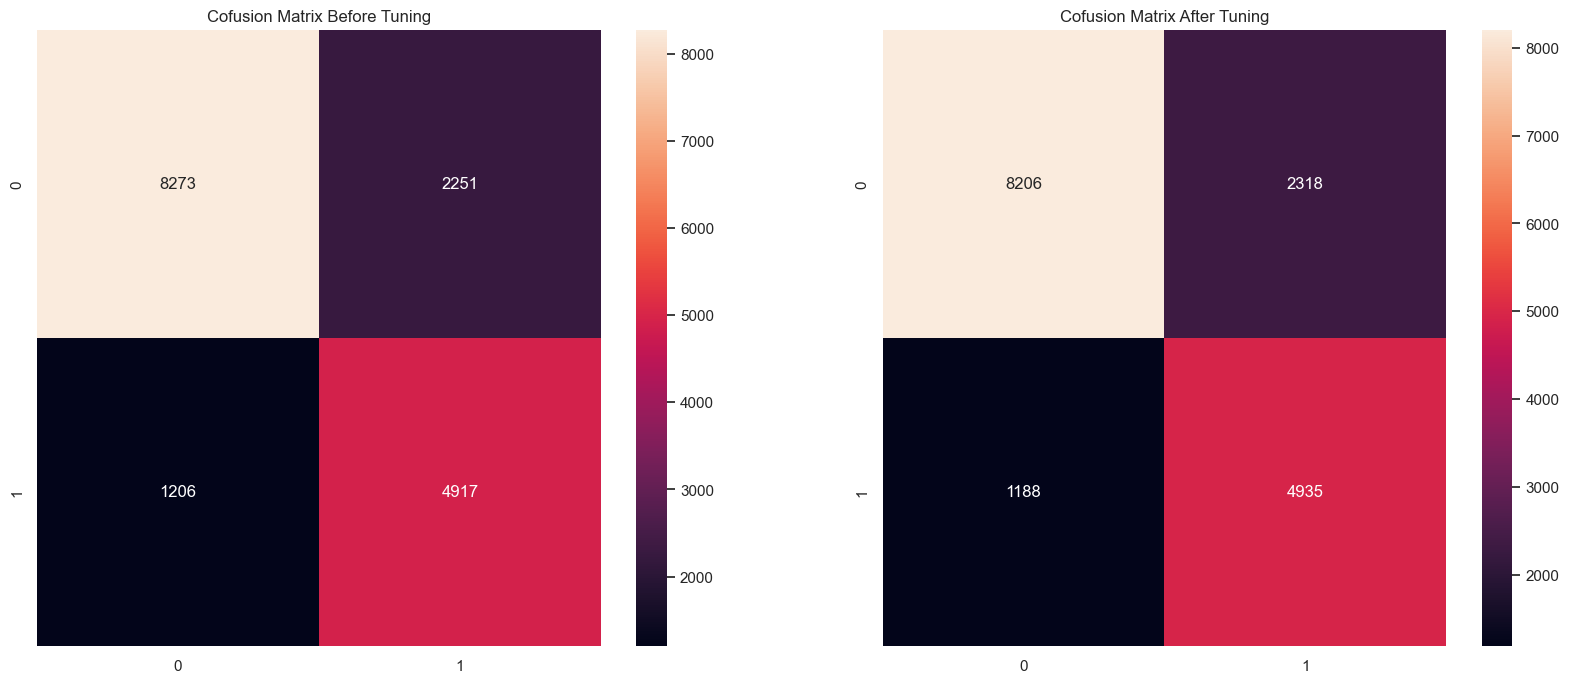

In [166]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,y_pred_before_xg),annot=True,fmt='.0f')
plt.title('Cofusion Matrix Before Tuning')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_after_xg),annot=True,fmt='.0f')
plt.title('Cofusion Matrix After Tuning')

Summary:
- The best Algorithm to use is XGBoost
    - Random Forest before hyperparameter tuning Recall score: 0.8030377266046056
    - Random Forest After Hyperparameter tuning Recall score:  0.7855626326963907
    - Random Forest After Second Hyperparameter tuning Recall score:  0.7984648048342315
    - XGBoost before hyperparameter tuning Recall score: 0.8030377266046056
    - XGBoost after hyperparameter tuning Recall score: 0.8059774620284175

Because the XGBoost Recall score after hyperparameter tuning is the best, so we will use the parameter of XGBoost after tuning with parameter:

- Scaler: StandardScaler()
- Polynomial Degree: 3
- Resampler: RandomUnderSampler(random_state=0)
- XGBoost__subsample: 0.6
- XGBoost__min_child_weight: 1
- XGBoost__max_depth: 44
- XGBoost__gamma: 0.0
- XGBoost__colsample_bytree: 0.8

XGBoost Step-By-Step Process:


- Initialize the first decision tree: XGBoost starts by fitting an initial decision tree to the data. This tree makes predictions based on the features of the data.

- Fit additional decision trees to residual errors: After the first tree is fit, XGBoost fits additional decision trees to the residual errors from the first tree. The residual errors are the difference between the actual values and the predicted values from the first tree.

- Combine the outputs from all the trees: The outputs from all the decision trees are combined to make the final prediction. Each tree takes into account the previous trees and their predictions, building upon them to improve the accuracy of the overall model.

- Repeat the process: The process of fitting decision trees to residual errors is repeated many times, each time using the residual errors from the previous set of trees. This allows the model to continually improve and make more accurate predictions.

- Make predictions: Finally, the XGBoost model can be used to make predictions on new data. The model uses the decision trees and their outputs to make predictions based on the features of the new data.

## Comparison Scenario before and after Machine Learning

This is the false negative rate before using the machine learning: the proportion of individuals whom we predict will not cancel their plans, but actually do.

In [45]:
y.value_counts()[1]/y.value_counts().sum()

0.36781526336024606

This is the false negative rate after using the machine learning: the proportion of individuals whom we predict will not cancel their plans, but actually do.

In [46]:
true_negative = confusion_matrix(y_test,y_pred_after_xg)[0][0]
false_positive = confusion_matrix(y_test,y_pred_after_xg)[0][1]
false_negative = confusion_matrix(y_test,y_pred_after_xg)[1][0]
true_positive = confusion_matrix(y_test,y_pred_after_xg)[1][1]

this code is to see the percentage of our missing profit before using machine learning

In [47]:
(true_positive+false_negative) / (true_positive+false_negative+true_negative+false_positive)

0.3678140205442422

this code is to see the percentage of our missing profit after using machine Learning

In [48]:
false_negative / (true_positive+false_negative+true_negative+false_positive)

0.07136420976752568

By utilizing an average hotel room cost of $140, we can calculate the financial loss experienced prior to the implementation of our machine learning model.

In [167]:
140*(1188+4935)

857220

By utilizing an average hotel room cost of $140, we can calculate the financial loss experienced after to the implementation of our machine learning model.

In [168]:
140*1188

166320

In [169]:
140*(true_positive+true_negative+false_negative+false_positive)

2330580

# Scenario How The Machine Learning Help Our Business

Prior to utilizing the machine learning model, our company experienced a shortfall in profits, amounting to 36.7% of the total potential earnings, equating to $857,220 from    $2,330,580 potential total earnings in USD. However, with the implementation of the machine learning model, we were able to significantly reduce this missing profit to just 7.1% of the total potential earnings, resulting in a decrease to $166,320 in USD for our loss.

## Model Limitation

- Our data only have 10 features:
    - because of the limitation of our limited features so our data can be under-trained so the Machine Learning is not optimized

- Range Data:
    - This model can only predict accurately:
        - Previous_cancellations : 0 - 26
        - Booking_Changes : 0 - 21
        - Days In Waiting List : 0-125
        - Required Car Parking Spaces : 0 - 8
        - Total Of Special Requests : 0 - 5

- Outliers:
    - There's still outliers in our data

# Model Performance Recommendation:
Things we can do to increase our model performance:

- Monitor performance regularly: Regular monitoring of the model's performance can help identify areas for improvement and make adjustments accordingly.

- Consider adding more data: The model's performance can be improved by incorporating more relevant data such as customer demographics, past booking history, etc.

- Test and validate the model: Regular testing and validation of the model can help ensure that it is working accurately and effectively.

- Collaborate with experts: Collaborating with machine learning experts and utilizing their expertise can help in further optimizing the model's performance.

# Business Recommendation:
- Our machine learning model boasts a realistic and impressive score of 80.3%, which falls within the ideal range of 75-90% for business purposes. This allows us to accurately predict the likelihood of customer cancellations well in advance of their booking date. By utilizing this model in our daily operations, we can effectively re-sell or re-list rooms if a cancellation does occur, thereby maximizing potential revenue and minimizing loss. Ultimately, our machine learning model represents a valuable asset to our business and a sound investment.

- There are several steps that a hotel can take to increase customer loyalty and reduce cancellations:

    - Provide excellent customer service: Providing outstanding customer service can help build strong relationships with customers and increase their likelihood of returning.

    - Offer incentives and rewards: Offering incentives and rewards such as loyalty programs, special discounts, and upgrades can encourage customers to choose your hotel over others.

    - Enhance the guest experience: Improving the guest experience by offering comfortable rooms, modern amenities, and convenient services can increase customer satisfaction and loyalty.

    - Personalize the experience: Personalizing the guest experience by remembering their preferences, offering tailored recommendations, and providing a warm and welcoming atmosphere can help build strong relationships with customers.

    - Utilize technology: Utilizing technology such as mobile check-in, in-room automation, and online booking can improve the guest experience and increase customer satisfaction.

    - Solve problems promptly: Responding promptly to customer complaints and proactively addressing any issues can help maintain customer trust and satisfaction.

    - Continuously gather and analyze customer feedback: Gathering and analyzing customer feedback regularly can help identify areas for improvement and provide valuable insights into what customers value most.

By taking these steps, hotels can increase customer satisfaction, build strong relationships with customers, and ultimately reduce cancellations.

# Feature Importance

Getting the columns name that we binary and scale

In [120]:
col_binary_scale = transformer.transformers_[0][1][1].get_feature_names_out()
col_binary_scale

['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7']

Getting the columns name that we onehot

In [128]:
col_onehot = transformer.transformers_[1][1][0].get_feature_names_out()
col_onehot = col_onehot.tolist()
col_onehot

['market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'reserved_room_type_B',
 'reserved_room_type_C',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'reserved_room_type_F',
 'reserved_room_type_G',
 'reserved_room_type_H',
 'reserved_room_type_L',
 'reserved_room_type_P']

Getting the columns name that we poly and scale

In [147]:
col_poly_scaling = randomsearch_xg.best_estimator_['transformer'].transformers_[2][1].get_feature_names_out()
col_poly_scaling = col_poly_scaling.tolist()
col_poly_scaling

['1',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'previous_cancellations^2',
 'previous_cancellations booking_changes',
 'previous_cancellations days_in_waiting_list',
 'previous_cancellations required_car_parking_spaces',
 'previous_cancellations total_of_special_requests',
 'booking_changes^2',
 'booking_changes days_in_waiting_list',
 'booking_changes required_car_parking_spaces',
 'booking_changes total_of_special_requests',
 'days_in_waiting_list^2',
 'days_in_waiting_list required_car_parking_spaces',
 'days_in_waiting_list total_of_special_requests',
 'required_car_parking_spaces^2',
 'required_car_parking_spaces total_of_special_requests',
 'total_of_special_requests^2',
 'previous_cancellations^3',
 'previous_cancellations^2 booking_changes',
 'previous_cancellations^2 days_in_waiting_list',
 'previous_cancellations^2 required_car_parking_spaces',
 'previous_cancellations^2 total_of_spe

making feature importance series

In [152]:
feature_imp = pd.Series(randomsearch_xg.best_estimator_['model'].feature_importances_,col_all)

This is the code for showing the barplot feature that have the highest importance

<AxesSubplot: >

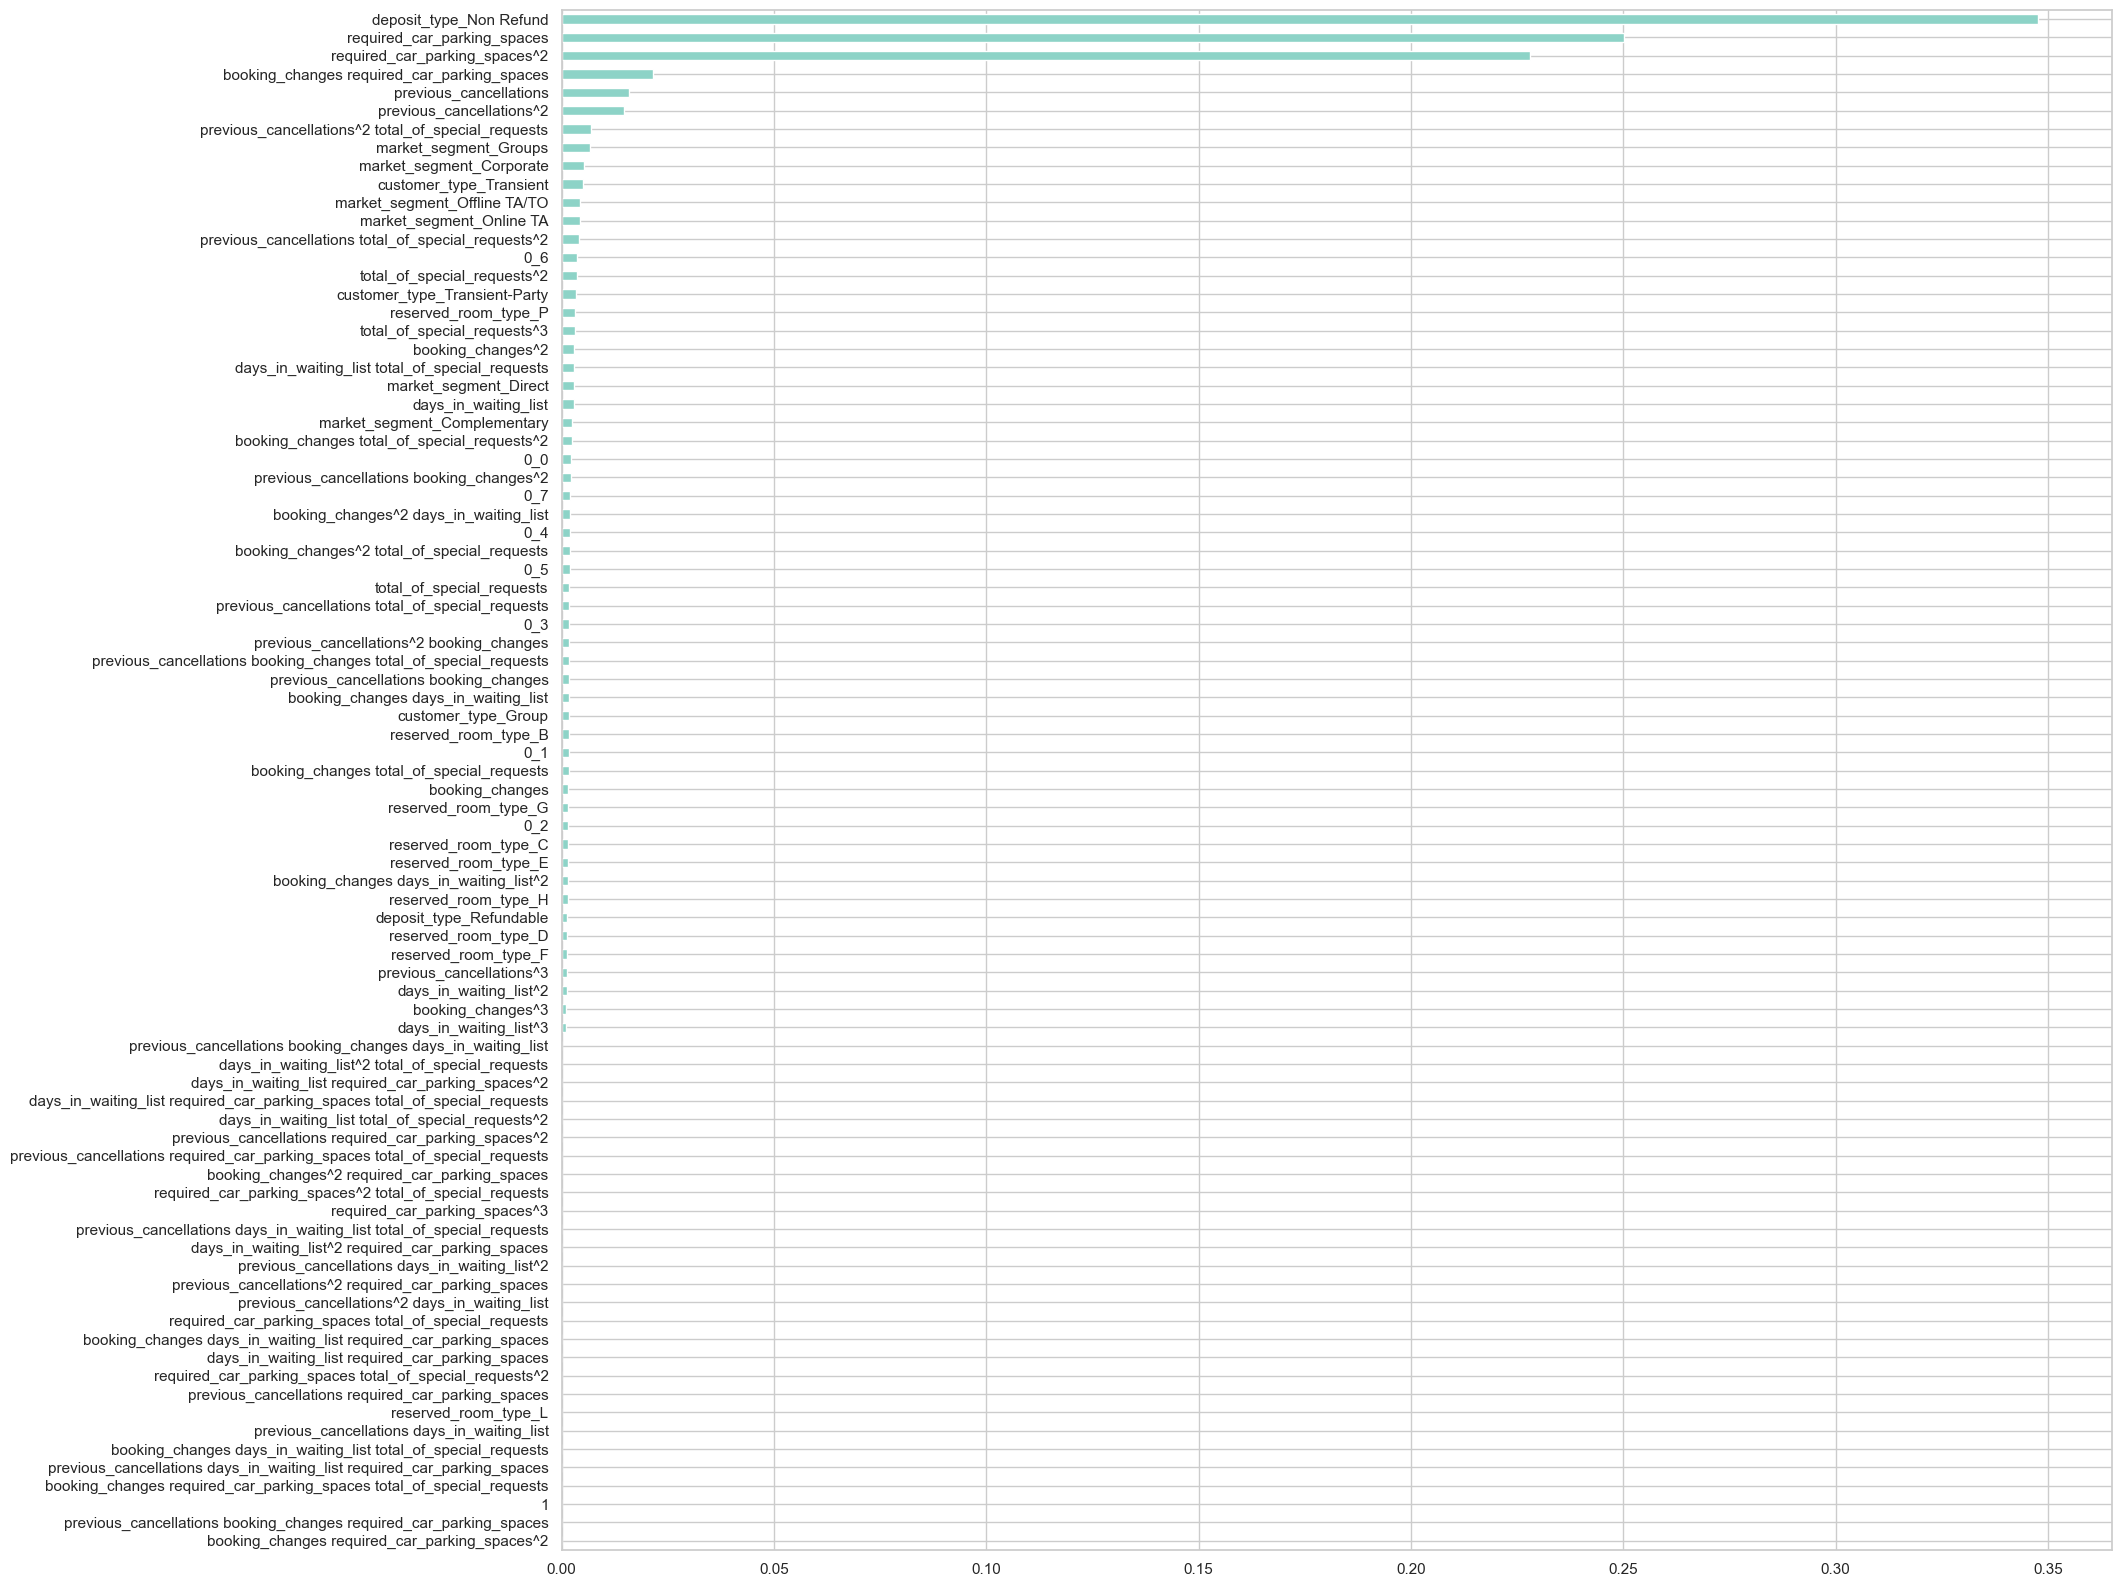

In [157]:
plt.figure(figsize=(20,20))
feature_imp.sort_values().plot(kind='barh')

The Top 5 Feature Most Important:
- Deposit Type Non Refundable                   : Customer Less Likely To Cancel If their Deposit Is Not Refundable
- Required Car Parking Spaces                   : Customer Who Made Special Request Of Car Parking Spaces Is Less Likely To Cancel 
- Required Car Parking Spaces ^ 2               : Customer Who Made Special Request Of Car Parking Spaces Is Less Likely To Cancel
- Booking Changes Required Car Parking Spaces   :
- Previous Cancellation                         : People With High Count Of Previous Cancellation Is More Likely To Cancel And The Other Way Around

# Conclusion

Why should we use the machine learning model for our daily operation?

- There are several ways in which your machine learning model can increase your profit:

    - Improved customer retention: By accurately predicting customer cancellations, you can proactively address potential issues and retain customers who might have otherwise cancelled.

    - Improved decision making: The insights and predictions generated by the model can inform and guide your business decisions, reducing the risk of costly mistakes and increasing overall profitability.

    - Enhanced marketing and promotions: The model can help you identify and target high-value customers, increasing the effectiveness of your marketing and promotional efforts.

By leveraging the power of machine learning, you can gain a competitive advantage, streamline operations, and increase profits.

it's also important to note that while machine learning can be a powerful tool for increasing profits, it's important to use it ethically and responsibly. Ensure that you are transparent with customers about how their data is being used and obtain their consent when necessary. Additionally, make sure that your model is fair, unbiased, and does not discriminate against any particular group of people.
By following these ethical principles, you can not only increase profits, but also build trust and credibility with your customers, partners, and stakeholders.



 ---
 ---
 # Save Model Pickle

In [51]:
randomsearch_xg.best_params_

{'transformer__pipe_poly_scaling__scaling': StandardScaler(),
 'transformer__pipe_poly_scaling__poly__degree': 3,
 'sampling': RandomUnderSampler(random_state=0),
 'model__subsample': 0.6,
 'model__min_child_weight': 1,
 'model__max_depth': 44,
 'model__gamma': 0.0,
 'model__colsample_bytree': 0.8}

In [52]:
import pickle

model = XGBClassifier(max_depth=38, gamma=0.2, colsample_bytree = 0.8, min_child_weight=3,subsample=0.9)

pipe_model_xg = Pipeline([
    ('transformer',transformer),
    ('sampling',RandomUnderSampler()),
    ('model', model)
])

pipe_model_xg.fit(X_train,y_train)

pickle.dump(pipe_model, open('Model_Hotel_Booking_Cancelation_Prediction_XGBoost_Fix.sav','wb'))
